# Decision Trees

For the following decision tree task we will use the Iris dataset. This dataset contains the sepal and petal width and length for three different iris species (Schwertlilien):
![iris-dataset.png](attachment/iris-dataset.png)

This is a common dataset to illustrate multi-class classification and we will use this later in our decision tree example to classify the species based on those measured leaf dimensions.

## Preprocessing

In the following we will use pandas method chaining to prepare the dataset.


In [22]:
import pandas as pd
import numpy as np
import networkx as nx
from pyvis.network import Network
import warnings
warnings.filterwarnings('ignore')
colorblind = ['#0072B2',
              '#E69F00',
              '#F0E442',
              '#009E73',
              '#56B4E9',
              '#D55E00',
              '#CC79A7',
              '#000000'
              ]

In [23]:
from functools import wraps

def log_name(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\n{func.__name__}:")
        return result
    return wrapper

def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\tshape: {result.shape}")
        return result
    return wrapper

def log_columns(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\tcolumns: {result.columns.values}")
        return result
    return wrapper

@log_columns
@log_shape
@log_name
def load(df, path):
    """Loads the dataset from path."""
    df = pd.read_csv(path)
    return df

In [ ]:
@log_columns
@log_shape
@log_name
def convert_to_categorical(df, col_name: str):
    df[col_name] = df[col_name].astype("category")
    return df

Next we add the column 'class' to the dataset. E.g. this column should contain a 0 if the species of the row is 'Iris-setosa', a 1 if the species of the row is 'Iris-versicolor' and a 2 if the species is 'Iris-virginica'.

In [ ]:
@log_columns
@log_shape
@log_name
def add_class_labels(df):
    df["class"] = df.species.cat.rename_categories([0, 1, 2])
    return df

Next we use the dataframe `.pipe()` method to chain the previously implemented `load`, `convert_to_categorical`, and `add_class_labels` functions to one preprocessing step:

In [ ]:
df = pd.DataFrame()
df = (
    df.pipe(load, path='iris.csv')
      .pipe(convert_to_categorical, col_name='species')
      .pipe(add_class_labels)
)


load:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']

convert_to_categorical:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']

add_class_labels:
	shape: (150, 6)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species'
 'class']


Now that we have the class labels, we can start implementing our first decision tree.

To be more precise, we will implement a
- **binary**: each node stands for a split into two classes
- **classification**: we want to decide based on the features of the leaves to which iris species the flower belongs to
- **tree**

So each split involves one of the four features and one condition (e.g. `petal_width < 1.1`). With each split we want to reduce the impurity of the resulting leaves as much as possible. To define this impurity we first need to define a cost function:

## Cost function

We will implement the entropy measure:

In information theory entropy is a measure of the average uncertainty in a random variable. Referring to a split of the dataset, the entropy tells us about the randomness in each part of the dataset.
It is defined as:
\begin{align}
H(X) &= - \sum_i^n p_i(x) \cdot log_2(p_i(x))
\end{align}
Each possible realization $x$ (each possible class label) of the discrete random variable $X$ (the class) has a given probability to occur. E.g. in our initial dataset the probability for each class label is $\frac{1}{3}$.  
Entropy is basically a weighted sum of the logarithm of these probabilities. Our random variable $X$ here is the class label.

Now we implement the `entropy` function, that calculates the entropy of a datasets for a given class column.

In [ ]:
def entropy(df: pd.DataFrame, y_col: str) -> float:
    """Calculates the entropy in a dataset for a specific class column.
    
    Args:
        df: Dataset as pandas dataframe.
        y_col: The label of the column that conatins the classes, e.g. 'species'.
        
    Returns:
        e: The entropy of df[y_col] in bits.
        
    Example:
    >>> e = entropy(df, 'species')
    """

    value_counts = df[y_col].value_counts(normalize=True)
    
    e = -1 * sum([vc * np.log2(vc) for vc in value_counts if vc != 0])
    
    return e

## Greedy strategy

Next we need to find the splits. We will start with the full dataset `df` using all 4 features `['sepal_length', 'sepal_width', 'petal_length', 'petal_width']`.  
First we can calculate the node impurity as the entropy of our whole dataset.  

For each unique value of each feature we can split the dataset with a `<=` condition.  
E.g. we split the dataset by the condition `'sepal_length' <= 6.4`
The subset that fulfills this condition we call the *left* split and subset that doesn't fulfill this condition we call the *right* split. This naming convention simply defines how to visually order the tree.

Now we get the subsets for the above mentioned condition and calculate the entropy of the left and right subset for the `'species'`. We also assign the resulting entropies to `left_e` and `right_e` respectively.

In [28]:
left = df.where(df["sepal_length"] <= 6.4)
right = df.where(df["sepal_length"] > 6.4)

left_e = entropy(left, "species")
right_e = entropy(right, "species")

So we now have the new entropies for this split. But how do we compare it to the entropy before?

This is the point where the information gain comes in. Information gain is used in the nomenclature of decision trees to describe how much information we gained by splitting the dataset. In the latter case it is a synonym for the Kullback-Leibler divergence. We will describe the gain of information by splitting the dataset in the following:

By splitting the dataset we obtain subsets of different sizes:

In [29]:
print(df[df['sepal_length'] <= 6.4].shape[0])
print(df[df['sepal_length'] > 6.4].shape[0])

115
35


What we can do now is to calculate the difference between the original entropy in the dataset and the individual entropies of the subsets weighted by their size:
\begin{align}
IG(split) &= E(X) - \left( \frac{|X_{left}|}{|X|} \cdot E(X_{left}) + \frac{|X_{right}|}{|X|} \cdot E(X_{right}) \right)
\end{align}
...where $|\_|$ stands for the number of samples in the respective subset.

Now we implement the function `information_gain`, so that it calculates the information gain for the `y_col` on a given dataframe `df` when it is split on the column `split_col` with a `<=` condition on the `split_val`. Additionally, to the information gain, also return the left and right entropy:

In [30]:
def information_gain(df: pd.DataFrame, split_col: str, split_val: float, y_col: str) -> float:
    """Calculates the information gain of a split.
    
    Args:
        df: Dataset before split as pandas dataframe.
        split_col: Column which is split by a <= condition on:
        split_val: ...
        y_col: Column with the class labels on which we want to reduce entropy.
        
    Returns:
        IG: The information gain in bits.
        left_e: the entropy of the left split.
        right_e: the entropy of the right split.
        
    Example:
        information_gain(df, 'sepal_length', 6.4, 'species')
    """

    e_x = entropy(df, y_col)
    
    #left = df.where(df[split_col] <= split_val)
    #right = df.where(df[split_col] > split_val)
    left = df[df[split_col] <= split_val]
    right = df[df[split_col] > split_val]
    

    left_e = entropy(left, y_col)
    right_e = entropy(right, y_col)
    
    size_left = left.shape[0]
    size_right = right.shape[0]
    size = df.shape[0]
    
    IG = e_x - ((size_left / size) * left_e + (size_right / size) * right_e)
    
    return IG, left_e, right_e

To classify our dataset, we want to reduce the impurity - in our case the entropy - in the splits of the dataset as far as possible. We can now calculate the information gain, so the reduction in entropy for arbitrary splits. Thereby we are able to greedy select the split with the highest information gain.

## Building the Tree

### Splitting
We first write a function for splitting and thus implement the `greedy_split` function such that it finds the split on all features with the largest information gain and returns a dictionary with the information on the split. If there is no split with an information gain, the node is pure and the function must return a dictionary that only contains the node entropy before the split:

In [31]:
def greedy_split(df: pd.DataFrame, x_cols: list, y_col: str) -> dict:
    """Finds the split with the largest information gain.
    
    Args:
        df: Dataset before split as pandas dataframe.
        x_cols: The labels of the feature columns.
        y_col: The column with the class labels.
        
    Returns:
        split: A dictionary with the keys `feature`, `value`, `ig`, `left_e`, `right_e`, and `node_e`.
               Returns {'node_e': val} if no split with an information gain>0 was found.
        
    Example:
        >>> x_cols = df.columns[:3]
        >>> y_col = 'species'
        >>> greedy_split(df, x_cols, y_col)
        >>> {'feature': 'petal_length', 
             'value': 1.9, 
             'ig': 0.9182958340544894, 
             'left_e': 0.0, 
             'right_e': 1.0, 
             'node_e': 1.584962500721156
             }
    """
    split_dict = {
        'feature': None, 
        'value': None, 
        'ig': 0, 
        'left_e': None, 
        'right_e': None, 
        'node_e': None
    }
    max_IG = 0
    for split_col in x_cols:
        for split_val in df[split_col]:
            IG, left_e, right_e = information_gain(df, split_col, split_val, y_col)
            
            if IG > max_IG:
                split_dict["feature"] = split_col
                split_dict["value"] = split_val
                split_dict["ig"] = IG
                split_dict["left_e"] = left_e
                split_dict["right_e"] = right_e
                split_dict["node_e"] = entropy(df, y_col)
                max_IG = IG
    
    if split_dict["ig"] != 0:
        return split_dict
    else:
        return {"node_e": entropy(df, y_col)}

In [32]:
x_cols = df.columns[:3]
y_col = 'species'
split = greedy_split(df, x_cols, y_col)

assert split['feature'] == 'petal_length'
assert split['value'] == 1.9
assert abs(np.round(split['ig'], 3)- 0.918) <= 0.01
assert abs(np.round(split['left_e']) - 0) <= 0.01

assert len(greedy_split(df[:50], x_cols, y_col)) == 1

Now we can build our `DecisionTree` class. We keep acting on dataframes as this keeps track of the meta data. For the fit method we simply define the feature columns (`x_cols`) and the label column (`y_col`).   
As additional hyperparameters we define a maximum depth (`max_depth`) at which splitting should be stopped and a number of samples at which no further splits shall be performed (`stop_n`).

As our decision tree is basically a directed graph we will use the python networkx (`nx`) graph library to represent this.
**We still need to implement the `_fit()` and `_predict()` methods.**

Both of them are recursive methods that should terminate on certain conditions:

### `_fit()`
This method takes the current subset `df`, information about the node id of the parent node (`parent`), the level of the tree (`level`), and the direction of the split where the current subset originated from (`direction`, 'left' or 'right').  
Your implementation should return as soon as either the node is pure (`len(split) == 1`), the `level` reached the `max_depth`, or the number of samples in the dataset is `<= stop_n`.  
Those end nodes are called *leaf* nodes.  

Otherwise, the current subset should be split and each part should be passed to `_fit()`.
As the tree is build in the `_add_node()` method, nothing has to be returned.


### `_predict()`
This method takes a dataset and traverses it through the tree structure. When it did not reach a leaf node it simply performs a split, passes the new subsets on to the left and right node of the next level and then returns the labels obtained from the previous `_predict` calls on the subset.  

When it reaches a leaf node it should create a pandas Series object with the row index of the current subset. As values the Series contains the category (`'cat'` in the node dict) of the node (e.g. `pd.Series({0: 'Iris-setosa', 3: 'Iris-setosa'})`). It then extends the current labels with the newly created Series and returns it.  

Step by step this should create an unordered Series that contains the predicted class labels for all samples in the dataset.  
On the level of the `predict()` method an unordered Series with the predicted labels of all samples in df is needed to append them as new column to the dataframe and return it.


In [33]:
class DecisionTree:
    
    def __init__(self):
        self.G = nx.DiGraph()
        self.cmap = None
        self.classes = None
        self.x_cols = None
        self.y_col = None
        self.max_depth = None
        self.stop_n = None
    
    def fit(self, df, x_cols, y_col, max_depth=10, stop_n=1):
        self.classes = df[y_col].unique()
        self.x_cols = x_cols
        self.y_col = y_col
        self.max_depth = max_depth
        self.stop_n = stop_n
        self.cmap = {self.classes[n]: c for n, c in enumerate(colorblind[:len(self.classes)])}
        self._fit(df)
        return
        
    def _fit(self, df, parent=-1, level=0, direction=None):
        """Recursive method to generate the tree.
        
        This method recursively splits the dataset till either the node is pure (len(split) == 1),
        the level reached max_depth (excluding the parent node, hence the initial level is 0),
        or the current subset has fewer or an equal amount of samples as stop_n.
        
        Args:
            df: The current subset.
            parent: the parent idx.
            level: the level in the tree.
            direction: 'left' or 'right' depending on whether df originate from a left or right split.
        """

        split = greedy_split(df, self.x_cols, self.y_col)
        

        if level >= self.max_depth or len(split) == 1 or df.shape[0] <= self.stop_n:
            # 'leaf'-node
            idx = self._add_node(split, df, parent, level, direction, 'leaf')
        
        else:
            # 'split'-node
            idx = self._add_node(split, df, parent, level, direction, 'split')

            df_left = df[df[split["feature"]] <= split["value"]] 
            df_right = df[df[split["feature"]] > split["value"]]

            new_level = level + 1

            self._fit(df_left, parent=idx, level=new_level, direction="left")
            self._fit(df_right, parent=idx, level=new_level, direction="right")
    
    def predict(self, df: pd.DataFrame) -> pd.Series:
        # appends an unordered Series with the predicted labels of all samples from the _predict() method 
        # appends them as new column to the dataframe and returns it
        predicted = self._predict(df)
        df[f'{self.y_col}_pred'] = predicted.astype('category')
        return df
    
    def _predict(self, df, idx=0, labels=pd.Series()):
        """Predicts the class labels for the subset df recursively.
        
        Args:
            df: The current subset as DataFrame.
            idx: The current node idx.
            labels: A pandas Series with increasing size the more leaf nodes were reached.
            
        Returns:
            labels: The labels of all samples in the initial df in a pandas Series.
            
        Example:
            >>> predicted = self._predict(df)
            >>> df[f'{self.y_col}_pred'] = predicted.astype('category')
   
        """
        # You don't need to change these two lines:
        n = self.G.nodes[idx] # nodes of the constructed tree
        # Looks like this:
        # {'shape': 'box',
        #  'color': '#E69F00',
        #  'label': 'petal_length <= 1.9\nentropy = 1.58\nsamples = 120\nvalues = [43 39 38]\nclass = Iris-setosa',
        #  'level': 0,
        #  'cat': 'Iris-setosa',
        #  'title': 'split',
        #  'feature': 'petal_length',
        #  'value': 1.9}
        
        edges = self.G[idx] # edges of the constructed tree
        # Looks like this:
        # {12: {'title': 'left'},
        #  17: {'title': 'right'}}
        # The keys are the node ids of the destination of the edge.
        
        # You should start with the case of a leaf node where your solution should
        # extend the current labels with the newly created series and return it.
        # 
        # Then implement the case where the dataset has to be split,
        # and the new subsets have to be passed on to the left and right node of the next level
        # then define labels obtained from the previous _predict calls on the subset
        

        if n["title"] == "leaf":
            return pd.Series(
                data=[n["cat"] for _ in range(df.shape[0])],
                index=df.index.values
            )
        
        else:
            feature = n["feature"]
            value = n["value"]
            
            df_left = df[df[feature] <= value]
            df_right = df[df[feature] > value]
            
            for idx, child in edges.items():
                if child["title"] == "left":
                    idx_left = idx
                elif child["title"] == "right":
                    idx_right = idx
                
            labels_left = self._predict(df_left, idx=idx_left, labels=labels)
            labels_right = self._predict(df_right, idx=idx_right, labels=labels)
            
            labels = pd.concat([labels_left, labels_right])
            
        
        return labels

    def _add_node(self, split, df, parent, level, direction, node_type):
        """Adds the node to the networkx graph.
        
        Args:
            split: the split resulting from greedy_split.
            df: the current dataset of the node.
            parent: the parent idx.
            level: the level in the tree.
            direction: 'left' or 'right' depending on whether df originate from a left or right split.
            node_type: 'split' or 'leaf'.
            
        Returns:
            idx: the current node idx
        """
        idx = len(self.G.nodes())
        cat = df[self.y_col].value_counts().idxmax()
        label = (f"entropy = {np.round(split['node_e'], 2)}\n"
                 f"samples = {df.shape[0]}\n"
                 f"values = {df[self.y_col].value_counts().values}\n"
                 f"class = {cat}"
                )
        if node_type == 'leaf':
            self.G.add_node(idx,
                            shape='ellipse',
                            color=self.cmap[cat],
                            label=label,
                            level=level,
                            cat=cat,
                            title=node_type
                           )
            self.G.add_edge(parent, idx, title=direction)
            return idx
        label = f"{split['feature']} <= {split['value']}\n"+label
        self.G.add_node(idx,
                        shape='box',
                        color=self.cmap[cat],
                        label=label,
                        level=level,
                        cat=cat,
                        title=node_type,
                        feature=split['feature'],
                        value=split['value']
                       )
        if parent >= 0:
            self.G.add_edge(parent, idx, title=direction)
        return idx        
    
    def plot(self):
        net = Network(height=900,
                      width=900,
                      notebook=True,
                      directed=True,
                      layout='hierarchical',
                      cdn_resources='in_line')
        net.from_nx(self.G)
        net.set_options(
            """
            var options = {
              "layout": {
                "hierarchical": {
                  "enabled": true,
                  "nodeSpacing": 120
                }
              },
              "physics": {
                "hierarchicalRepulsion": {
                  "centralGravity": 0,
                  "nodeDistance": 180
                },
                "minVelocity": 0.75,
                "solver": "hierarchicalRepulsion"
              }
            }
            """
        )
        return net

In [34]:
x_cols = df.columns[:3]
y_col = 'species'

clf = DecisionTree()
clf.fit(df, x_cols, y_col)
pred = clf.predict(df)
assert np.all(pred[y_col] == pred[f'{y_col}_pred'])
assert max(nx.shortest_path_length(clf.G,0).values()) == 9


### Plotting
We can plot the fitted tree with the following code. Pyvis generates an interactive html file, which we can use to explore the graph:

In [35]:
net = clf.plot()
net.show('tree.html')

tree.html


# Validation and hyperparameter tuning
It doesn't make any sense to fit a decision tree on the full dataset and then validate it on the same dataset.

In Machine Learning you usually do at least a train-validation split: You split the dataset and use e.g. 80% to fit your model and the other 20% to predict and test the performance of your model on unseen data.

![crossvalidation](attachment/crossvalidation.png)

Additionally, one usually does a cross-validation: In the case of a 80:20 split we can train the model on five different combinations of independent data.

So here we would use the first 20% for testing and train on the remaining part, then we use the second 20% for testing and use the other 80% for training and so on. The goal is to find model hyperparameters that show a good and stable performance amongst all splits.

But how to determine performance in our case?

## Metrics for multi-class classification

### Confusion matrix
We can simply make a matrix with the true labels on the y-axis and the predicted labels on the x-axis. In our case this would be a 3 x 3 matrix. In each cell of the matrix we put the number of cases the specific constellation happened. E.g. in cell (y=1, x=2) we would put the number of times the model predicted 'Iris-versicolor' but the actual label was 'Iris-setosa'. The diagonal would contain all correct predictions.

### Accuracy
The accuracy is simply:
\begin{align}
Accuracy &= \frac{Number\,of\,correct\,predictions}{Total\,number\,of\,predictions}
\end{align}

Okay first of all we implement a confusion matrix.
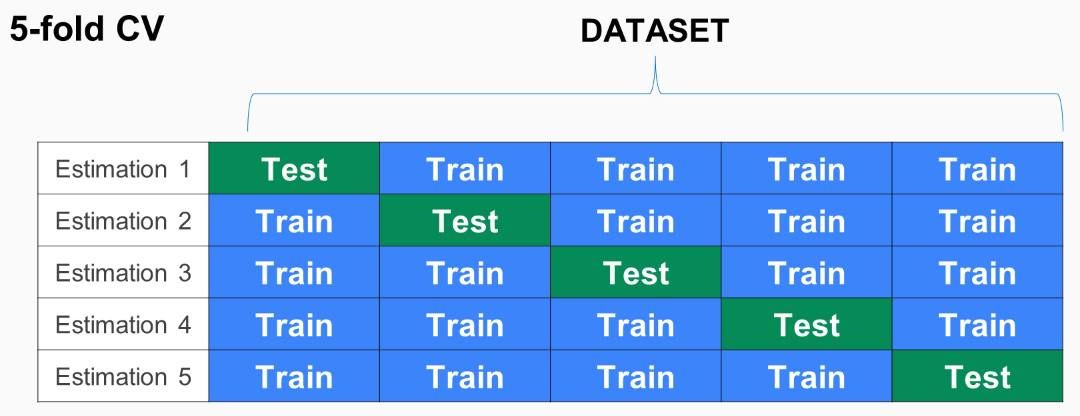

In [36]:
x_cols = df.columns[:3]
y_col = 'species'

shuffled = df.sample(frac=1, random_state=42)

train = shuffled[:120]
test = shuffled[120:]

clf = DecisionTree()
clf.fit(train, x_cols, y_col)
pred = clf.predict(test)

confusion_matrix = pd.DataFrame(index=df['species'].unique(),
                                columns=df['species'].unique(),
                                data = np.zeros((3,3)))
confusion_matrix.index.name = 'True'
confusion_matrix.columns.name = 'Predicted'



pred["pred_class"] = pred.species_pred.cat.rename_categories([0, 1, 2])

for i, row in pred.iterrows():
    confusion_matrix.iloc[row["class"]][row["pred_class"]] += 1
    
confusion_matrix

Predicted,Iris-setosa,Iris-versicolor,Iris-virginica
True,,,
Iris-setosa,7.0,0.0,0.0
Iris-versicolor,0.0,10.0,1.0
Iris-virginica,0.0,2.0,10.0


Okay now we can start tuning our model. First we implement the accuracy calculation:

In [37]:
def accuracy(df, y_col):

    true = df[y_col].to_list()
    pred = df[f"{y_col}_pred"].to_list()
    acc = sum([1 for t, p in zip(true, pred) if t == p]) / df.shape[0]
    
    return acc

In [38]:
assert abs(accuracy(pred, y_col) - 0.9) <= 0.1 

## Hyperparameter tuning
Now let's vary the max_depth and the stop_n in a defined grid (below in the code) and do a 5-fold cross validation for each parameter combination. We work on the shuffled dataset without further reshuffling for the splits and write the mean accuracies to the `mean_accs` dataframe.


In [39]:
x_cols = df.columns[:3]
y_col = 'species'

max_depths = [4, 7, 10]
stop_ns = [1, 3, 6]

shuffled = df.sample(frac=1, random_state=42)

mean_accs = pd.DataFrame(index=max_depths, columns=stop_ns)
mean_accs.index.name = "max depth"
mean_accs.columns.name = "stop n"


k = 5
folds = np.array_split(shuffled, k)

for md in max_depths:
    for sn in stop_ns:
        print("parameter configuration:")
        print(f"  max depth: {md}")
        print(f"  stop n: {sn}")
        
        accs = np.zeros(k)
        for i in range(k):
            # select one fold as test set and the other ones as training set
            df_test = folds[i]
            df_train = pd.concat(folds[0:i] + folds[i+1:k])
            
            # build decition tree
            clf = DecisionTree()
            
            # train it
            clf.fit(df_train, x_cols, y_col, max_depth=md, stop_n=sn)
            
            # make prediction on test set
            pred = clf.predict(df_test)
            
            # evaluate prediction
            accs[i] = (accuracy(pred, y_col))
        mean_acc = np.mean(accs)
        mean_accs.loc[md][sn] = mean_acc
        
        print("result:")
        print(f"  mean accuracy: {mean_acc}\n\n")
        
mean_accs

parameter configuration:
  max depth: 4
  stop n: 1
result:
  mean accuracy: 0.9333333333333333


parameter configuration:
  max depth: 4
  stop n: 3
result:
  mean accuracy: 0.9333333333333333


parameter configuration:
  max depth: 4
  stop n: 6
result:
  mean accuracy: 0.9333333333333333


parameter configuration:
  max depth: 7
  stop n: 1
result:
  mean accuracy: 0.9199999999999999


parameter configuration:
  max depth: 7
  stop n: 3
result:
  mean accuracy: 0.9266666666666665


parameter configuration:
  max depth: 7
  stop n: 6
result:
  mean accuracy: 0.9266666666666665


parameter configuration:
  max depth: 10
  stop n: 1
result:
  mean accuracy: 0.9199999999999999


parameter configuration:
  max depth: 10
  stop n: 3
result:
  mean accuracy: 0.9266666666666665


parameter configuration:
  max depth: 10
  stop n: 6
result:
  mean accuracy: 0.9266666666666665




stop n,1,3,6
max depth,,,
4,0.933333,0.933333,0.933333
7,0.92,0.926667,0.926667
10,0.92,0.926667,0.926667


In general in ML one tries to find a model with the best performance, in our case the highest accuracy, and the lowest complexity to avoid overfitting and reduce computational cost. Based on this, what combination of parameters should we choose for our decision tree?

In [40]:
max_depth = 4
stop_n = 6